# Monte Carlo class usage

![Landing point dispersion elipses](https://github.com/RocketPy-Team/RocketPy/raw/master/docs/notebooks/dispersion_analysis/dispersion_analysis_outputs/valetudo_rocket_v0.svg)

This is an advanced use of RocketPy. This notebook runs a Monte Carlo analysis and predicts probability distributions of the rocket's landing point, apogee and other relevant information. 

The `MonteCarlo` class simplifies the process of performing Monte Carlo simulations. The idea is to take the already defined classes for a standard flight simulation, and create the so called ``Stochastic`` classes, which are used to run the Monte Carlo analysis.

This class offers extensive capabilities, and this example notebook covers as many as possible.
For a deeper understanding, we recommend checking the class [documentation](https://docs.rocketpy.org/en/latest/).

For a more comprehensive conceptual understanding of Monte Carlo Simulations, refer to RocketPy's main reference: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331).



In [30]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's import the necessary libraries

In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo, Function
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
import datetime

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib widget

## Step 1: Standard Simulation


We will first create a standard RocketPy simulation objects (e.g. Environment, SolidMotor, etc.) to then create the Stochastic objects.

The standard objects created here are the same as in the [First Simulation Page](https://docs.rocketpy.org/en/latest/user/first_simulation.html) of our documentation, so you can go through that if you want to understand what is done in more detail.

The only difference here is that we will use a `Environment` with atmospheric model type `Ensemble`. This allows us to run the Monte Carlo analysis with different ensemble members, which are different atmospheric profiles.

We will do it all in one single cell for simplicity.

In [32]:
# Environment
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type="Ensemble", file="GEFS")

# Motor
motor = SolidMotor(
    thrust_source="../../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
print(f"Total Impulse of the Solid Motor: {motor.total_impulse} Ns")

# Rocket
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Flight
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)


Total Impulse of the Solid Motor: 6026.35 Ns


Lets check the trajectory of the Flight.

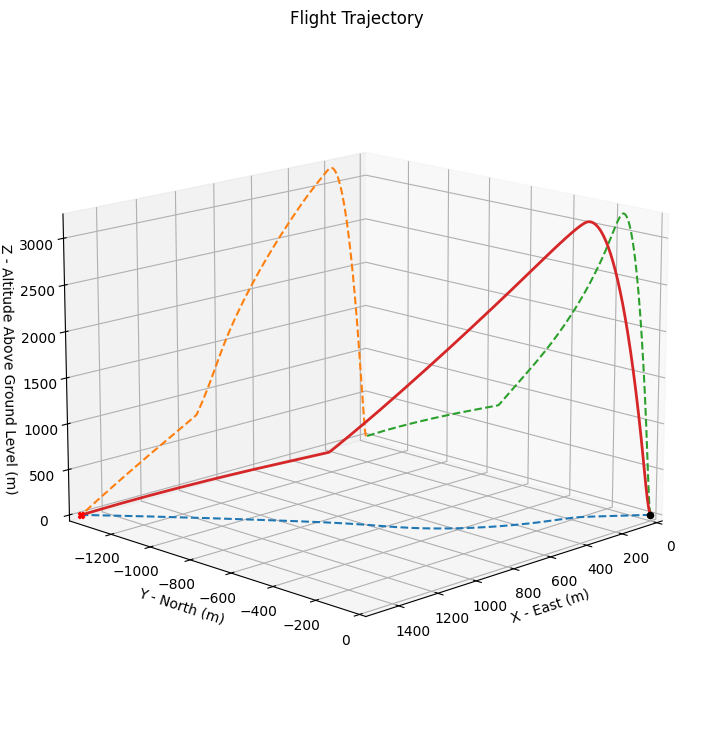

In [68]:
test_flight.plots.trajectory_3d()

The flight trajectory above represents the nominal trajectory of the rocket, without any uncertainties.


## Step 2: Stochastic Objects

For each RocketPy object, we will create a ``Stochastic`` couterpart that extends the initial model, allowing us to define the uncertainties of each input parameter.

The idea of the ``Stochastic`` classes is to take the standard classes and add uncertainties to the input parameters. This is done by constructing distributions for each parameter, and then sampling from these distributions to create a new object for each simulation.

In terms of initialization parameters, the ``Stochastic`` classes are very similar to the standard classes. The main difference is that they receive the standard object as an argument. The rest of the parameters are the same as the standard classes. **The standard object received will be used as the default nominal value for all the distribuitions.**

Here is a better explanation of the parameters:

- All ``Stochastic`` classes **must** receive the standard object as an argument. This is the only mandatory parameter.

- The remaining parameters are the same as the standard classes, and they are optional. They need only be passed if you want to define the standard deviation for a (possibly) chosen distribuition of that parameter. If you don't pass a parameter, it will be considered as a deterministic value taken from the standard object.

- Some ``Stochastic`` classes have additional parameters that are not present in the standard classes. These are used for specific purposes, such as changing the total impulse of a motor, or a multiplication factor for the drag curves or wind speeds.


<div class="alert alert-block alert-success"> 

#### **Important**


Furthermore, the optional parameters (which define the uncertainties) can be passed in a few different ways:

- **As a single value:** This will define the standard deviation for that parameter. The default distribuition used will be a normal distribuition and the nominal value will be the value of that same parameter from the standard object.

- **As a tuple of two numbers:** The first number will define the nominal value of the distribuition, and the second number will define the standard deviation. The default distribuition used will be a normal distribuition.

- **As a tuple of two numbers and a string:** The first number will define the nominal value of the distribuition, the second number will define the standard deviation, and the string will define the distribuition type. The distribuition type can be distributions *"normal"*, *"binomial"*, *"chisquare"*, *"exponential"*, *"gamma"*, *"gumbel"*, *"laplace"*, *"logistic"*, *"poisson"*, *"uniform"* and *"wald"*.

- **As a tuple of a number and a string:** The number will define the standard deviation, and the string will define the distribuition type. The nominal value will be the value of that same parameter from the standard object.

- **As a list of values:** The values will be randomly chosen from this and used as the parameter value during the simulation. You can not define standard deviations when using lists.

 </div>


Starting with the `Environment` object, we will create a `StochasticEnvironment` to specify its uncertainties.

In this first example, we will specify the ensemble member and wind velocities factor.

Since the ensemble member is a discrete value, **only list type inputs are permitted**. The list will contain the ensemble numbers to be randomly selected during the Monte Carlo simulation. This means that in each iteration, a different ensemble member will be chosen.

The wind velocities factor are also special inputs. They are used to scale the wind velocities in each axis. The factor inputs can only be tuples or lists, since it has no nominal value to get from the standard. Lets scale the wind by a factor of 1.00000 ± 0.2

In [44]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
    wind_velocity_x_factor=(1, 0.2),
    wind_velocity_y_factor=(1, 0.2),
)

stochastic_env

object: <rocketpy.environment.environment.Environment object at 0x000001BD7FB36BA0>
last_rnd_dict: {}
elevation: [113]
gravity: ['Function from R1 to R1 : (height (m)) → (gravity (m/s²))']
latitude: [39.3897]
longitude: [-8.288964]
wind_velocity_x_factor: 1.00000 ± 0.20000 (numpy.random.normal)
wind_velocity_y_factor: 1.00000 ± 0.20000 (numpy.random.normal)
datum: ['SIRGAS2000']
timezone: ['UTC']
ensemble_member: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

<div class="alert alert-block alert-info"> 

#### NOTE

Always check the printing of the object to see if the uncertainties were correctly set.

</div>



Just to illustrate the potential of this technique, let's randomly generate 5 instances of the environment using the `create_object` method.

For each instance, we will calculate the wind speed at 1km altitude and store the results in a list.

In [45]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = stochastic_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[3.740092684250815, 4.9381130538062425, 3.9988061871142895, 2.767140726386856, 3.6032724506858345]


As you can see, the wind speed varies between ensemble members.
This demonstrates how the Monte Carlo simulation can capture the variability in wind conditions due to different ensemble members.


### Motor


We can now create a `StochasticSolidMotor` object to define the uncertainties associated with the motor.
In this example, we will apply more complex uncertainties to the motor parameters.

The `StochasticSolidMotor` also has one special parameter which is the `total_impulse`. It lets us alter the total impulse of the motor while maintaining the thrust curve shape. This is particularly useful for motor uncertainties.

In [51]:
stochastic_motor = StochasticSolidMotor(
    solid_motor=motor,
    thrust_source=[
        "../../../data/motors/Cesaroni_M1670.eng",
        [[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]],
        Function([[0, 5900], [1, 6000], [2, 6100], [3, 5900], [4, 5800]]),
    ],
    burn_start_time=(0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
stochastic_motor

object: <rocketpy.motors.solid_motor.SolidMotor object at 0x000001BD7FB369C0>
last_rnd_dict: {}
thrust_source: ['../../../data/motors/Cesaroni_M1670.eng', [[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]], 'Function from R1 to R1 : (Scalar) → (Scalar)']
total_impulse: 6500.00000 ± 1000.00000 (numpy.random.normal)
burn_start_time: 0.00000 ± 0.10000 (numpy.random.binomial)
burn_out_time: [3.9]
dry_mass: [1.815]
dry_I_11: [0.125]
dry_I_22: [0.125]
dry_I_33: [0.002]
dry_I_12: [0]
dry_I_13: [0]
dry_I_23: [0]
nozzle_radius: 0.03300 ± 0.00050 (numpy.random.normal)
grain_number: [5]
grain_density: 1815.00000 ± 50.00000 (numpy.random.normal)
grain_outer_radius: 0.03300 ± 0.00038 (numpy.random.normal)
grain_initial_inner_radius: 0.01500 ± 0.00038 (numpy.random.normal)
grain_initial_height: 0.12000 ± 0.00100 (numpy.random.normal)
grain_separation: 0.00500 ± 0.00100 (numpy.random.normal)
grains_center_of_mass_position: 0.39700 ± 0.00100 (numpy.random.normal)
center_of_dry_mass_position: [0.3

<div class="alert alert-block alert-info"> 

#### NOTE

Pay special attention to how different input types are interpreted in the `StochasticSolidMotor` object by checking the printed object:


- ``thrust_source`` was given as a list of 3 items, and is saved as is. This means that the simulation will randomly chose one item of that list, as desired

- ``burn_start_time`` was given as a tuple of 3 items, specifying the nominal value, the standard deviation and the distribuition type

- ``total_impulse`` was given as a tuple of 2 numbers, so the distribuition type was set to the default: `normal`

- All other values set for the other parameters in the constructor are simple values, which means they are interpreted as standard deviation and the nominal value is taken from the ``motor``

- The remaining parameters that are printed are just the nominal values from the ``motor``. In the ``Stochastic`` object they are saved as a list of one item

 </div>



Once again, we can illustrate the power of stochastic modeling by generating multiple instances of the `SolidMotor` class using the `StochasticSolidMotor` object.
For each instance, we will calculate the total impulse and store the results in a list. This will show how the uncertainties in the motor parameters affect the total impulse over multiple iterations.


In [56]:
total_impulse = []
for i in range(5):
    rnd_motor = stochastic_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[5922.730109775586, 5397.418437730037, 8888.401049795124, 2867.149759762836, 6583.48945300187]


### Rocket


We can now create a `StochasticRocket` object to define the uncertainties associated with the rocket.

In [60]:
stochastic_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
stochastic_rocket

object: <rocketpy.rocket.rocket.Rocket object at 0x000001BD7FB35430>
last_rnd_dict: {}
radius: 0.06350 ± 0.00001 (numpy.random.normal)
mass: 15.42600 ± 0.50000 (numpy.random.normal)
I_11_without_motor: 6.32100 ± 0.00000 (numpy.random.normal)
I_22_without_motor: 6.32100 ± 0.01000 (numpy.random.normal)
I_33_without_motor: 0.03400 ± 0.01000 (numpy.random.normal)
I_12_without_motor: [0]
I_13_without_motor: [0]
I_23_without_motor: [0]
power_off_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)']
power_on_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)']
power_off_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
power_on_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
center_of_mass_without_motor: 0.00000 ± 0.00000 (numpy.random.normal)
coordinate_system_orientation: ['tail_to_nose']
motors: Components:

aerodynamic_surfaces: Components:

rail_buttons: Components:

parachutes: []

The `StochasticRocket` still needs to have its aerodynamic surfaces and parachutes added. 

We can also create stochastic models for each aerodynamic surface, although this is not mandatory.

In [61]:
stochastic_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

stochastic_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

stochastic_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

Then we must add them to our stochastic rocket, much like we do in the normal Rocket.



In [62]:
stochastic_rocket.add_motor(stochastic_motor, position=0.001)
stochastic_rocket.add_nose(stochastic_nose_cone, position=(1.134, 0.001))
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set, position=(0.001, "normal"))
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.set_rail_buttons(
    stochastic_rail_buttons, lower_button_position=(0.001, "normal")
)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

<div class="alert alert-block alert-info"> 

#### NOTE

The `position` arguments behave just like the other ``Stochastic`` classes parameters

 </div>



Now lets check how the `StochasticRocket` handled all these additions

In [66]:
stochastic_rocket

object: <rocketpy.rocket.rocket.Rocket object at 0x000001BD7FB35430>
last_rnd_dict: {}
radius: 0.06350 ± 0.00001 (numpy.random.normal)
mass: 15.42600 ± 0.50000 (numpy.random.normal)
I_11_without_motor: 6.32100 ± 0.00000 (numpy.random.normal)
I_22_without_motor: 6.32100 ± 0.01000 (numpy.random.normal)
I_33_without_motor: 0.03400 ± 0.01000 (numpy.random.normal)
I_12_without_motor: [0]
I_13_without_motor: [0]
I_23_without_motor: [0]
power_off_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)']
power_on_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)']
power_off_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
power_on_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
center_of_mass_without_motor: 0.00000 ± 0.00000 (numpy.random.normal)
coordinate_system_orientation: ['tail_to_nose']
motors: Components:
	Component: object: <rocketpy.motors.solid_motor.SolidMotor object at 0x000001BD7FB369C0>
last_rnd_dict: {}
thrust_


### Flight


After defining the `Flight`, we can create the corresponding `Stochastic` object to define the uncertainties of the input parameters.

In [67]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
stochastic_flight

object: <Flight(rocket= <rocketpy.rocket.rocket.Rocket object at 0x000001BD7FB35430>, environment= <rocketpy.environment.environment.Environment object at 0x000001BD7FB36BA0>, rail_length= 5, inclination= 84, heading = 133,name= Flight)>
last_rnd_dict: {}
rail_length: [5]
inclination: 84.70000 ± 1.00000 (numpy.random.normal)
heading: 53.00000 ± 2.00000 (numpy.random.normal)
initial_solution: None
terminate_on_apogee: None

### Step 2: Starting the Monte Carlo Simulations


First, let's invoke the `MonteCarlo` class, we are going to need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [20]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

c:\mateus\github\rocketpy\rocketpy\simulation\monte_carlo.py:97: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt
A total of 1000 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt

The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.errors.txt


Finally, let's simulate our flights. 
We can run the simulations using the method `MonteCarlo.simulate()`.

Set `append=False` to overwrite the previous results, or `append=True` to add the new results to the previous ones.


In [21]:
test_dispersion.simulate(number_of_simulations=1000, append=False)

Keyboard Interrupt, files saved.age Time per Iteration: 2.184 s | Estimated time left: 2116 s
Completed 32 iterations. Total CPU time: 68.9 s. Total wall time: 69.6 s
Saving results.     
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [24]:
# You only need to import results if you did not run the simulations
# test_dispersion.import_results()

In [22]:
test_dispersion.num_of_loaded_sims

31

In [23]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  31
Results: 

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
     out_of_rail_velocity          23.690           2.184
                 x_impact        1514.914         386.644
              apogee_time          25.657           2.347
          impact_velocity          -5.322           0.066
                 y_impact        -283.937         203.440
         out_of_rail_time           0.341           0.064
     frontal_surface_wind           0.887           0.591
                 apogee_y         751.781         141.018
                  t_final         304.216          37.176
          max_mach_number           0.866           0.144
                 apogee_x          87.831         126.183
     lateral_surface_wind          -5.351           0.415
                   apogee        3367.587  

Secondly, we can plot the results of the simulations.


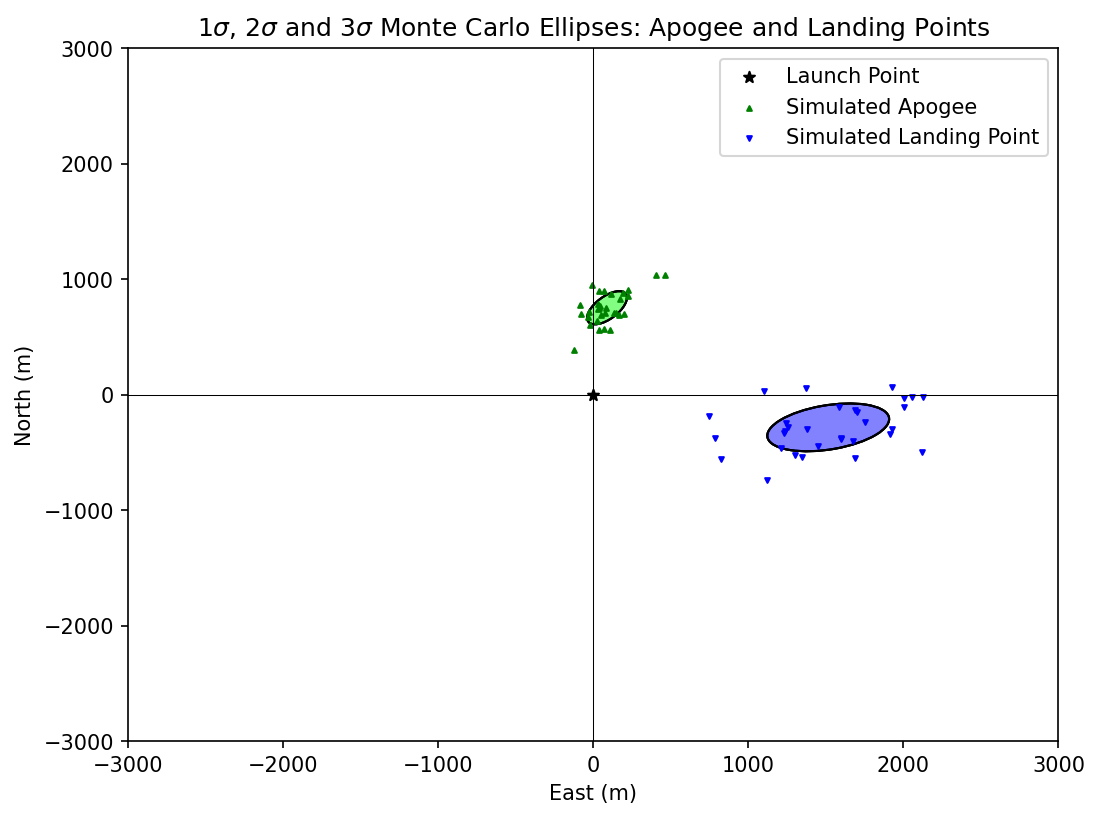

In [26]:
test_dispersion.plots.ellipses(xlim=(-200, 3500), ylim=(-200, 3500))

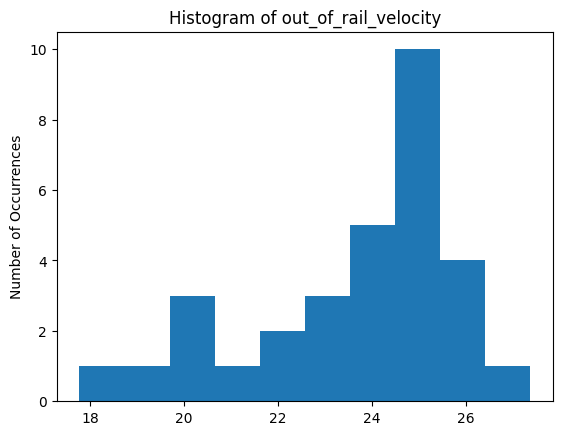

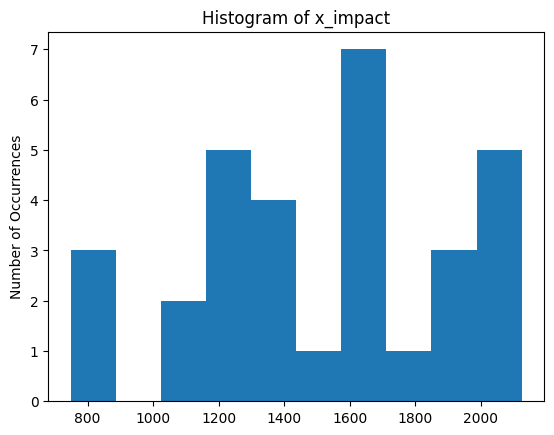

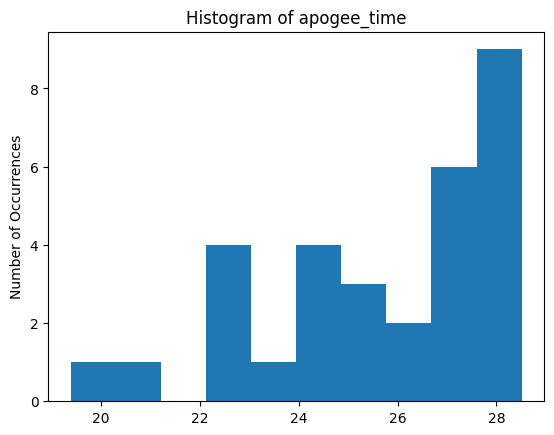

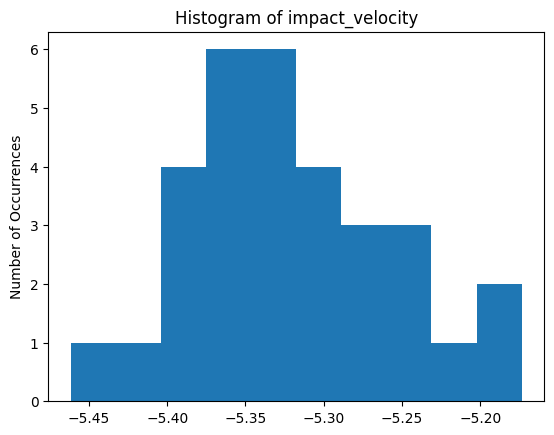

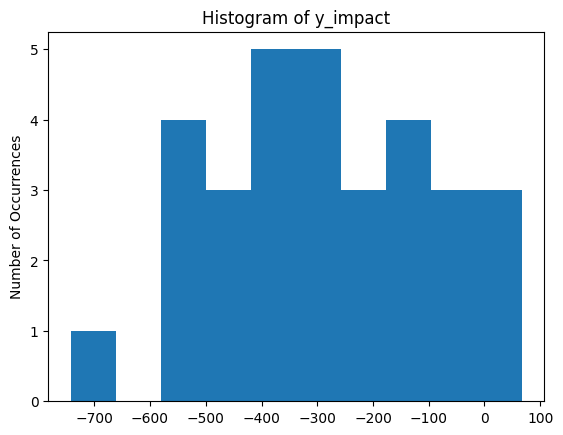

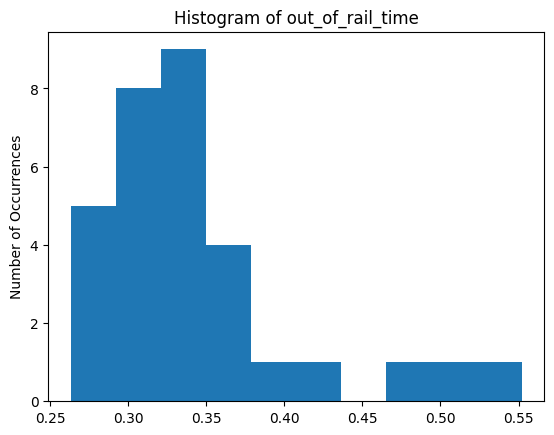

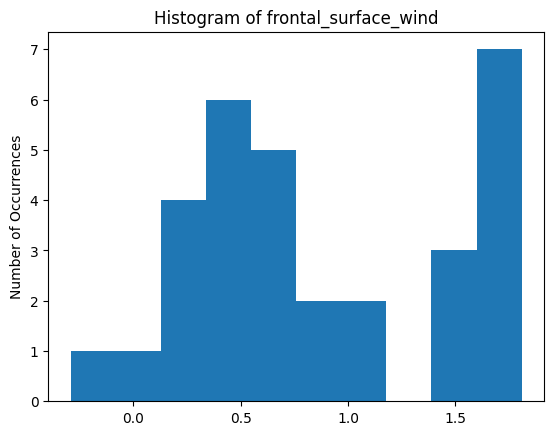

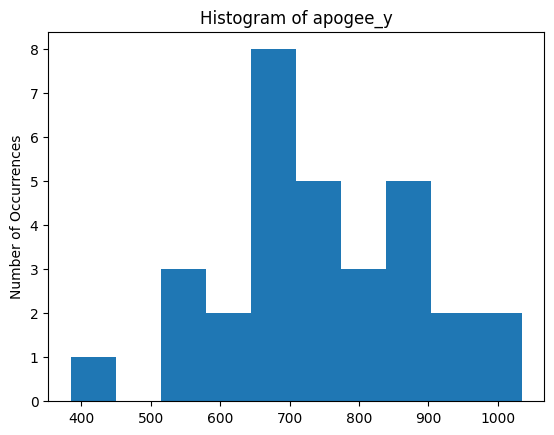

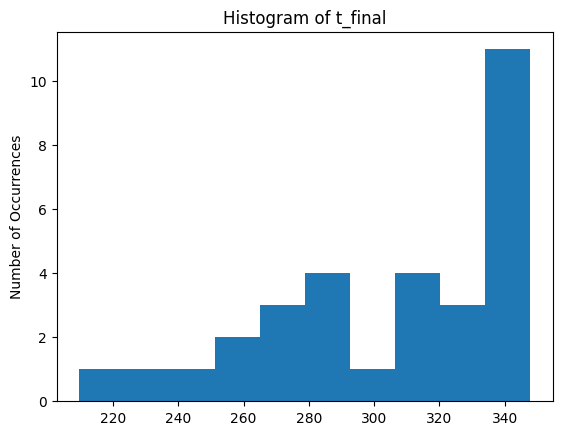

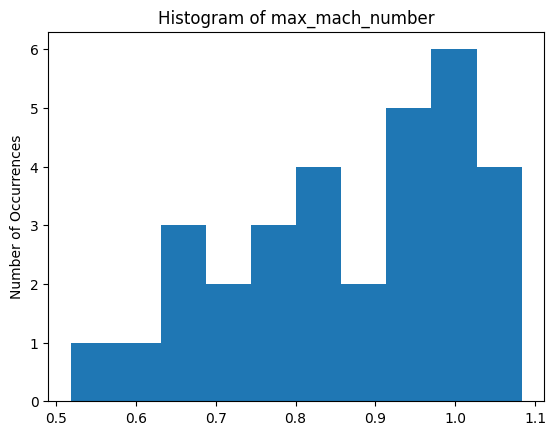

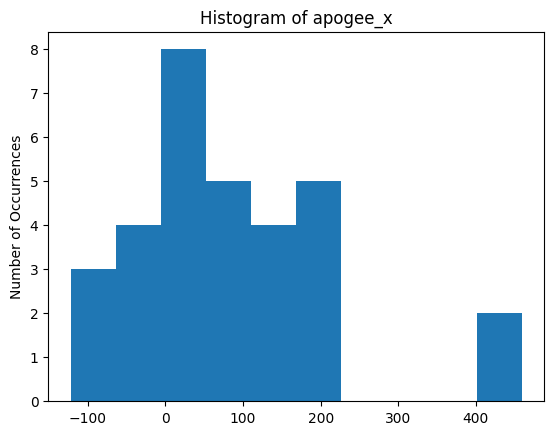

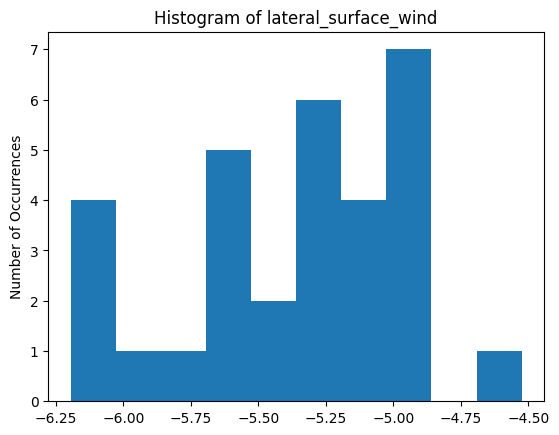

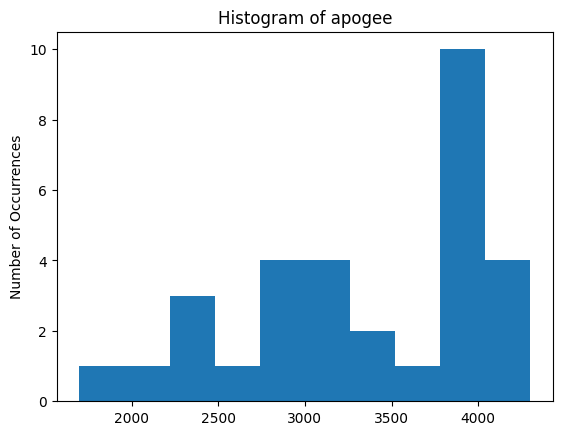

In [27]:
test_dispersion.plots.all()

Finally, one may also export the ellipses to a ``.kml`` file so it can be easily visualized in Google Earth


In [29]:
test_dispersion.export_ellipses_to_kml(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)